In [1]:
# load packages
import numpy as np 
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
from itertools import chain

In [2]:
rca_comp = 0 # rca component to look at 

In [3]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_Fx_OutputData\\RCA_Files\\' # set dir - on my computer
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Avilable Files to choose from: {len(d)}')
print(f'Files on hand: {d}')
##############################################
FileN_f1 = d[1] # choose one
FileN_f2  = d[3]                         
file_path1 = os.path.join(MainDir, FileN_f1) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

file_path2 = os.path.join(MainDir, FileN_f2) # join paths and prep 2 load
print('Current WD:',file_path2) # does path exist ... ?
print('Does File #2 Exist?',os.path.exists(file_path1)) # yes or no

Avilable Files to choose from: 5
Files on hand: ['desktop.ini', 'OfficialF1_Control_rcaResults_Sweep.mat', 'OfficialF1_rcaResults_Sweep_F2F4F6F8.mat', 'OfficialF2_Control_rcaResults_Sweep.mat', 'OfficialF2_rcaResults_Sweep_F2F4F6F8.mat']
Current WD: C:\plimon\LTP_analysis\RCA_Fx_OutputData\RCA_Files\OfficialF1_Control_rcaResults_Sweep.mat
Does File #1 Exist? True
Current WD: C:\plimon\LTP_analysis\RCA_Fx_OutputData\RCA_Files\OfficialF2_Control_rcaResults_Sweep.mat
Does File #2 Exist? True


In [4]:
df_f1 = scipy.io.loadmat(file_path1)
df_f2 = scipy.io.loadmat(file_path2)

In [5]:
rca_f1 = df_f1['rcaResult']['projectedData'][0,0]
f1 = [rca_f1[x,0] for x in range(rca_f1.shape[0])] # entry per subject

F1_noise = df_f1['rcaResult']['noiseData'][0,0]
noise_f1 = [F1_noise[x,0] for x in range(F1_noise.shape[0])][0][1]# entry per subject

In [6]:
rca_f2 = df_f2['rcaResult']['projectedData'][0,0]
f2 = [rca_f2[x,0] for x in range(rca_f2.shape[0])]

F2_noise = df_f2['rcaResult']['noiseData'][0,0]
noise_f2 = [F2_noise[x,0] for x in range(F2_noise.shape[0])][0][1]# entry per subject

In [7]:
# load subject names ...
SubNames = df_f1['rcaResult'][0,0][5]
NumSubs = int(len(SubNames))
FileName = [x[0][3:] for subjlist in SubNames for x in subjlist[0][2][0]]
print(f'Total Data Files: {len(FileName)}')

Total Data Files: 10


### This Section Plots Response and Noise on Average

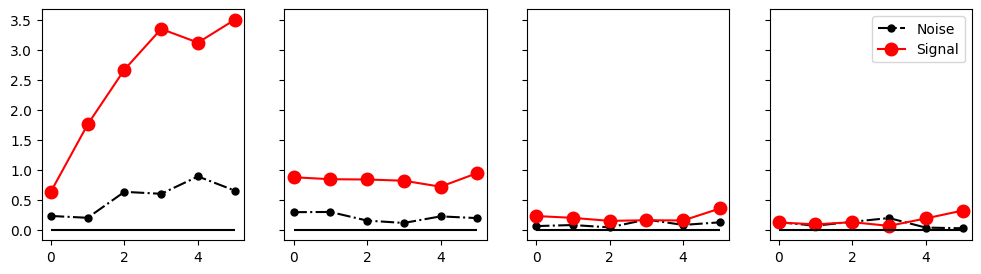

In [8]:
subn = 0

noise = np.array(noise_f1[subn][0][:,0,:])
sig = np.array(f1[subn][:,0,:])
noise[noise == 0] = np.nan # 47 x 78
sig[sig == 0] = np.nan

r,c = noise.shape
harmoniSegments=  np.arange(0,int(c/2),6)

realdf = noise[0:int(r/2)] # [24 x 78 ]
imaginarydf = noise[int(r/2):,:]
realSig = sig[0:int(r/2)]
imagSig = sig[int(r/2):,:]

Noise = np.zeros((4,6))
Signal = np.zeros((4,6))

hs_mat = []
hn_mat = []
for harm_sig in range(4):

    s = harmoniSegments[harm_sig]
    e = s+6

    reals = np.nanmean(realdf[s:e,:],axis = 1)
    imag = np.nanmean(imaginarydf[s:e,:],axis = 1)

    rS = np.nanmean(realSig[s:e,:],axis = 1)
    iS = np.nanmean(imagSig[s:e,:],axis = 1)

    Noise[harm_sig,:] = np.hypot(reals,imag)
    Signal[harm_sig,:] = np.hypot(rS,iS)

# print(Noise)
# print(Signal)

fig,axs = plt.subplots(1,4,figsize = ((12,3)),sharey = True)

for p in range(4):
    axs[p].plot(Noise[p,:],color = 'black',linestyle='-.', marker='o', markersize=5, label = 'Noise')
    axs[p].plot(Signal[p,:],color = 'red',linestyle='-', marker='o', markersize=9, label = 'Signal')
    axs[p].hlines(0,xmin = 0,xmax = 5, color = 'black')
axs[3].legend()

#### Plot Response and Noise Pre and Post

In [9]:
noise = np.array(noise_f1[subn][0][:,0,:])
sig = np.array(f1[subn][:,0,:])
noise[noise == 0] = np.nan # 47 x 78
sig[sig == 0] = np.nan

r,c = noise.shape
TrialCutoff = int(c/2)
harmoniSegments=  np.arange(0,int(c/2),6)

realdf =      noise[0:int(r/2)] # [24 x 78 ]
imaginarydf = noise[int(r/2):,:]
realSig =     sig[0:int(r/2)]
imagSig =     sig[int(r/2):,:]


PrePostSig = np.zeros((4,2,6))
PrePostNoise = np.zeros_like((PrePostSig))

for pp in range(2):
    if pp == 0:
        Inds = [0,TrialCutoff-1]
    else: 
        Inds = [TrialCutoff,TrialCutoff*2-1]

    for harm_sig in range(4):

        s = harmoniSegments[harm_sig]
        e = s+6

        realSi = realSig[s:e,Inds[0]:Inds[1]]
        imagSi = imagSig[s:e,Inds[0]:Inds[1]]

        realNo =  realdf[s:e,Inds[0]:Inds[1]]
        imagNo = imaginarydf[s:e,Inds[0]:Inds[1]]


        PrePostSig[harm_sig,pp,:]  = np.hypot(np.nanmean(realSi,axis = 1),np.nanmean(imagSi,axis = 1))
        PrePostNoise[harm_sig,pp,:]  = np.hypot(np.nanmean(realNo,axis = 1),np.nanmean(imagNo,axis = 1))


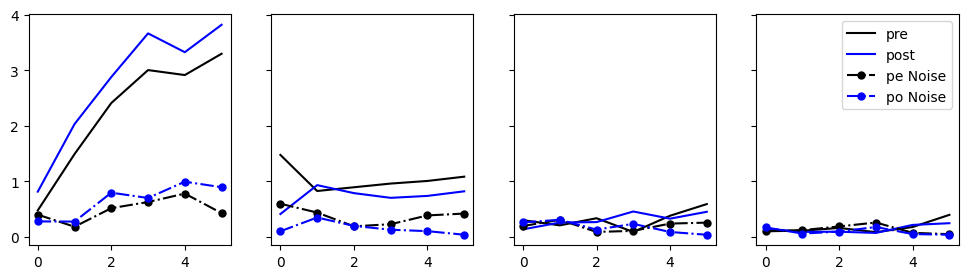

In [11]:
fig,axs = plt.subplots(1,4,figsize = ((12,3)),sharey = True)

for h in range(4):
    axs[h].plot(PrePostSig[h,0,:], color = 'black', label = 'pre')
    axs[h].plot(PrePostSig[h,1,:], color = 'blue', label = 'post')


    axs[h].plot(PrePostNoise[h,0,:], color = 'black',linestyle='-.', marker='o', markersize=5, label = 'pe Noise')
    axs[h].plot(PrePostNoise[h,1,:], color = 'blue',linestyle='-.', marker='o', markersize=5, label = 'po Noise')

axs[3].legend()